# **📈 Predicting StockX Sneaker Prices using SageMaker DeepAR**
---
----

## Contents

1. [Background](#Background)
1. [Setup](#Setup)
1. [Data](#Data)

---

## Background 
This notebook demonstrates time series forecasting using the Amazon SageMaker DeepAR alogrithm by analyzing Stockx sneaker prices.  


__Disclaimer__: Please note that I am a newbie to AI/ML. I built this project so I can further my own learning in Machine Learning. I am sharing it because I hope it can assist someone who is also on a similar journey as I am. 

---

## Setup 
This notebook was created and tested on a ml.m4.xlarge instance. 



### Enable Kaggle Tools 

What is Kaggle? Kaggle allows users to find and publish data sets, explore and build models in a web-based data-science environment, work with other data scientists and machine learning engineers, and enter competitions to solve data science challenges. You can find out more about Kaggle on their [website](https://www.kaggle.com/). 

We will be using Kaggle to download the Stockx sneaker sales dataset.

### Install Kaggle CLI

In [2]:
!pip install --q kaggle 


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


To use Kaggle API, you must have an account and an API token. You can register for a Kaggle account [here](https://www.kaggle.com/docs/api) and generate your API token, it is completely free. 

In [3]:
!touch ~/.kaggle/kaggle.json # Creates json file to store Kaggle API Credentials
kaggle_api_token = {"username":"gilbertyoungjr","key":"9c1e0b76bd43718e8bf816ac26e05824"}  # Insert your own username and API Key here

In [4]:
import json 

# Writes API Credentials to Kaggle file
with open('/root/.kaggle/kaggle.json', 'w') as file: 
    json.dump(kaggle_api_token,file)
    

For security reasons, we must ensure that other users of our computer do not have read access to our Kaggle credentials.

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

### Import Packages

In [6]:
import sagemaker
import boto3
import io
import json
import time

from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import pandas as pd

import s3fs


Let's start by specifying:

1. The S3 bucket and prefix that you want to use for training and model data. This should be within the same region as the notebook instance, training, and hosting.
1. The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these. Note, if more than one role is required for notebook instances, training, and/or hosting, please replace sagemaker.get_execution_role() with the appropriate full IAM role arn string(s).

In [7]:
sagemaker_session = sagemaker.Session() # Use to interact with SageMaker services
s3_bucket = sagemaker_session.default_bucket() # Return the name of the default bucket to use for SageMaker interactions.
s3_prefix = "sagemaker/stockx_sneaker_prices"  # Change to your desired S3 prefix
region = sagemaker_session.boto_region_name # Sets default region for SageMaker

# Defines data path to store files 
s3_data_path = "s3://{}/{}/data".format(s3_bucket, s3_prefix)
s3_output_path = "s3://{}/{}/output".format(s3_bucket, s3_prefix)
role = sagemaker.get_execution_role() # Return IAM Role used by SageMaker 


Next, we configure the container image to be used for the region that we are running in.

In [8]:
image_name = sagemaker.image_uris.retrieve("forecasting-deepar", region)
print(image_name)

522234722520.dkr.ecr.us-east-1.amazonaws.com/forecasting-deepar:1


---
## Data 
The dataset used in this project, is from the [StockX 2019 Data Contest](https://www.kaggle.com/datasets/hudsonstuck/stockx-data-contest).

The data consists of a random sample of all Off-White x Nike and Yeezy 350 sales from between 9/1/2017 (the month that Off-White first debuted “The Ten” collection) and the present. There are 99,956 total sales in the data set; 27,794 Off-White sales, and 72,162 Yeezy sales. The sample consists of U.S. sales only.

In [9]:
!kaggle datasets list # List available datasets
!kaggle datasets download -d hudsonstuck/stockx-data-contest --unzip --force # Downloads & Unzip dataset

ref                                                             title                                            size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  ----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
akshaydattatraykhare/diabetes-dataset                           Diabetes Dataset                                  9KB  2022-10-06 08:55:25          11786        372  1.0              
whenamancodes/covid-19-coronavirus-pandemic-dataset             COVID -19 Coronavirus Pandemic Dataset           11KB  2022-09-30 04:05:11           9403        289  1.0              
stetsondone/video-game-sales-by-genre                           Video Game Sales by Genre                        12KB  2022-10-31 17:56:01            965         23  1.0              
whenamancodes/credit-card-customers-prediction                  Credit Card Cust

Now that the dataset is downloaded, let us visualize what the data looks like. 

In [217]:
initial_data = pd.read_csv('StockX-Data-Contest-2019-3.csv', header = 0, parse_dates=['Order Date', 'Release Date'])
df = initial_data.copy()
df.head() # Display first 5 rows
#df.info() # Shows data type in frame

,Order Date,Brand,Sneaker Name,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region
0,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-Low-V2-Beluga,"$1,097",$220,2016-09-24,11.0,California
1,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Copper,$685,$220,2016-11-23,11.0,California
2,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Green,$690,$220,2016-11-23,11.0,California
3,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red,"$1,075",$220,2016-11-23,11.5,Kentucky
4,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017,$828,$220,2017-02-11,11.0,Rhode Island


### Data Cleaning 
The data is already somewhat nicely formatted for us, but there are still a few cleaning we have to do. 

1. Remove dashes ('-') from Sneaker Name 
1. Remove dollar sign ('$') and comma (',') from prices (Sales Price, Retail Price)
1. Convert Sale Price and Retail Price to type float 64

In [219]:
# Remove dashes ('-') from Sneaker Name 
df['Sneaker Name'] = df['Sneaker Name'].apply(lambda x: x.replace('-', ' '))
df.head()

,Order Date,Brand,Sneaker Name,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region
0,2017-09-01,Yeezy,Adidas Yeezy Boost 350 Low V2 Beluga,"$1,097",$220,2016-09-24,11.0,California
1,2017-09-01,Yeezy,Adidas Yeezy Boost 350 V2 Core Black Copper,$685,$220,2016-11-23,11.0,California
2,2017-09-01,Yeezy,Adidas Yeezy Boost 350 V2 Core Black Green,$690,$220,2016-11-23,11.0,California
3,2017-09-01,Yeezy,Adidas Yeezy Boost 350 V2 Core Black Red,"$1,075",$220,2016-11-23,11.5,Kentucky
4,2017-09-01,Yeezy,Adidas Yeezy Boost 350 V2 Core Black Red 2017,$828,$220,2017-02-11,11.0,Rhode Island


In [220]:
# Remove dollar sign ('$') and comma (',') from prices (Sales Price, Retail Price) 
# Converts values to type float64
df['Sale Price'] = df['Sale Price'].apply(lambda x: x.replace('$', ''))
df['Sale Price'] = df['Sale Price'].apply(lambda x: x.replace(',', ''))
df['Sale Price'] = df['Sale Price'].astype(float)
df['Retail Price'] = df['Retail Price'].apply(lambda x: x.replace('$', ''))
df['Retail Price'] = df['Retail Price'].apply(lambda x: x.replace(',', ''))
df['Retail Price'] = df['Retail Price'].astype(float)
df.head()

,Order Date,Brand,Sneaker Name,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region
0,2017-09-01,Yeezy,Adidas Yeezy Boost 350 Low V2 Beluga,1097.0,220.0,2016-09-24,11.0,California
1,2017-09-01,Yeezy,Adidas Yeezy Boost 350 V2 Core Black Copper,685.0,220.0,2016-11-23,11.0,California
2,2017-09-01,Yeezy,Adidas Yeezy Boost 350 V2 Core Black Green,690.0,220.0,2016-11-23,11.0,California
3,2017-09-01,Yeezy,Adidas Yeezy Boost 350 V2 Core Black Red,1075.0,220.0,2016-11-23,11.5,Kentucky
4,2017-09-01,Yeezy,Adidas Yeezy Boost 350 V2 Core Black Red 2017,828.0,220.0,2017-02-11,11.0,Rhode Island


In [221]:
# Renaming columns to remove spaces 
df = df.rename(columns={
    "Order Date": "order_date",
    "Brand": "brand",
    "Sneaker Name": "sneaker_name",
    "Sale Price": "sale_price",
    "Retail Price": "retail_price",
    "Release Date": "release_date",
    "Shoe Size": "shoe_size",
    "Buyer Region": "buyer_region"
    })
df.head()

,order_date,brand,sneaker_name,sale_price,retail_price,release_date,shoe_size,buyer_region
0,2017-09-01,Yeezy,Adidas Yeezy Boost 350 Low V2 Beluga,1097.0,220.0,2016-09-24,11.0,California
1,2017-09-01,Yeezy,Adidas Yeezy Boost 350 V2 Core Black Copper,685.0,220.0,2016-11-23,11.0,California
2,2017-09-01,Yeezy,Adidas Yeezy Boost 350 V2 Core Black Green,690.0,220.0,2016-11-23,11.0,California
3,2017-09-01,Yeezy,Adidas Yeezy Boost 350 V2 Core Black Red,1075.0,220.0,2016-11-23,11.5,Kentucky
4,2017-09-01,Yeezy,Adidas Yeezy Boost 350 V2 Core Black Red 2017,828.0,220.0,2017-02-11,11.0,Rhode Island


### Store Data to S3

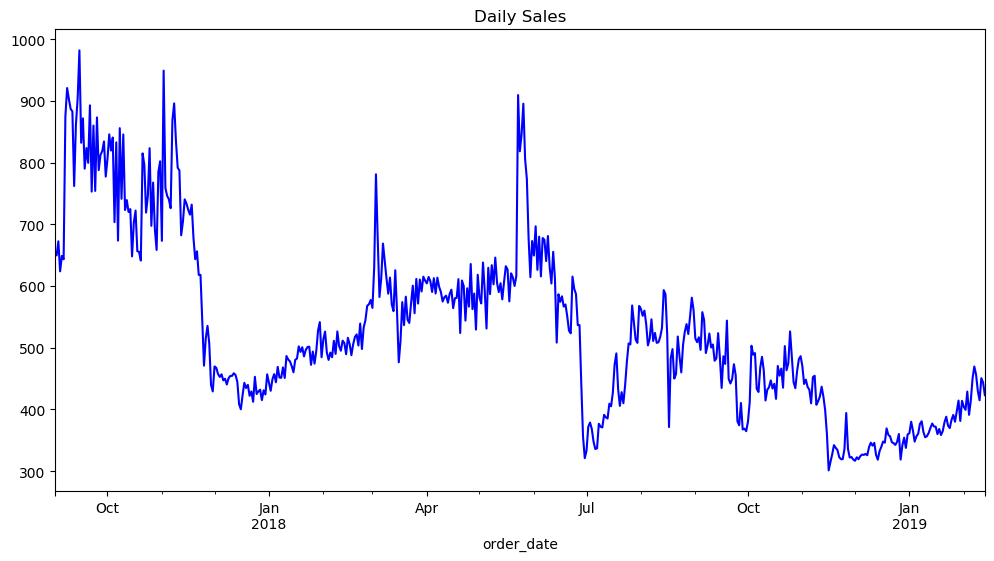

In [233]:
df_copy = df.resample('D', on='order_date')['sale_price'].mean()

plt.figure(figsize=(12,6))
df_copy.plot(title='Daily Sales', color='blue')
plt.show()

In [230]:
df['sneaker_name'].value_counts()

adidas Yeezy Boost 350 V2 Butter                     11423
Adidas Yeezy Boost 350 V2 Beluga 2pt0                10395
Adidas Yeezy Boost 350 V2 Zebra                      10110
Adidas Yeezy Boost 350 V2 Blue Tint                   9297
Adidas Yeezy Boost 350 V2 Cream White                 9097
Adidas Yeezy Boost 350 V2 Sesame                      5553
adidas Yeezy Boost 350 V2 Static                      4983
Adidas Yeezy Boost 350 V2 Semi Frozen Yellow          4854
Air Jordan 1 Retro High Off White University Blue     4635
adidas Yeezy Boost 350 V2 Static Reflective           3184
Nike Air Presto Off White Black 2018                  1884
Nike Air Presto Off White White 2018                  1883
Nike Air VaporMax Off White 2018                      1591
Nike Blazer Mid Off White All Hallows Eve             1435
Nike Blazer Mid Off White Grim Reaper                 1398
Nike Zoom Fly Off White Pink                          1359
Nike Air VaporMax Off White Black                     13